# Proyecto 03 - Series de Tiempo

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset para los años 2017, 2018 y 2019. Si deseas utilizar otros años, ten en cuenta que deberás hacer el preprocesamiento correspondiente, ya que la estructura de los datos puede variar.

**Importante:** Para el proyecto, debes comenzar con los datos de la autopista Illia, pago en Efectivo.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

### Predicción a Futuro

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?
1. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

### 1. Preparación del Dataset

# Exploracion de datos

In [1]:
import pandas
import numpy
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import sweetviz
import seaborn
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import plotly.offline as py

In [2]:
data_2019 = pandas.read_csv('traffic_data/flujo-vehicular-2019.csv', sep =',')
data_2018 = pandas.read_csv('traffic_data/flujo-vehicular-2018.csv', sep =',')
data_2017 = pandas.read_csv('traffic_data/flujo-vehicular-2017.csv', sep =',')
traffic_data = pandas.concat([data_2017, data_2018, data_2019])
traffic_data

,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,NO COBRADO,25
1,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,TELEPASE,7
2,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,NO COBRADO,5
3,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,2
4,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,94
...,...,...,...,...,...,...,...,...,...,...
812148,2019,2019-12-31,23,0,Martes,Salguero,Provincia,Liviano,NO COBRADO,7
812149,2019,2019-12-31,23,0,Martes,Salguero,Provincia,Liviano,TELEPASE,4
812150,2019,2019-12-31,23,0,Martes,Salguero,Provincia,Pesado,NO COBRADO,1
812151,2019,2019-12-31,23,0,Martes,Sarmiento,Provincia,Liviano,NO COBRADO,7


In [3]:
traffic_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3560706 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   periodo         int64 
 1   fecha           object
 2   hora_inicio     int64 
 3   hora_fin        int64 
 4   dia             object
 5   estacion        object
 6   sentido         object
 7   tipo_vehiculo   object
 8   forma_pago      object
 9   cantidad_pasos  int64 
dtypes: int64(4), object(6)
memory usage: 298.8+ MB


In [4]:
traffic_data.head()

,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,NO COBRADO,25
1,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,TELEPASE,7
2,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,NO COBRADO,5
3,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,2
4,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,94


In [5]:
traffic_data.tail()

,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
812148,2019,2019-12-31,23,0,Martes,Salguero,Provincia,Liviano,NO COBRADO,7
812149,2019,2019-12-31,23,0,Martes,Salguero,Provincia,Liviano,TELEPASE,4
812150,2019,2019-12-31,23,0,Martes,Salguero,Provincia,Pesado,NO COBRADO,1
812151,2019,2019-12-31,23,0,Martes,Sarmiento,Provincia,Liviano,NO COBRADO,7
812152,2019,2019-12-31,23,0,Martes,Sarmiento,Provincia,Liviano,TELEPASE,7


#### Conclusiones:

La tabla traffic_data representa un OLAP Cube cuyo fact es la cantidad de pasos, que significa el agregado de trafico vehicular dado cierta fecha, cierta hora, cierta estacion, cierto sentido, cierto vehiculo y cierta forma de pago. El origen de la tabla parece ser un peaje debido a que cuenta con una columna llamada forma de pago.

Despues de examinar los datos rapidamente podemos notar lo siguiente para cada una de las columnas:

1. Periodo: Representa el año de agregacion
2. Fecha: Representa la fecha de agregacion
3. Hora_inicio: Representa la hora de la agregacion
4. Hora_fin: Simplemente una hora adelante de la hora de inicio
5. Dia: Dia de la agregacion
6. Estacion: Estacion de la agregacion
7. Tipo_vehiculo: Tipo_vehiculo agregacion
8. Forma_pago: Forma de pago del peaje
9. Cantidad_de_pasos: Columna objetivo, es el total de vehiculos que pasaron por el peaje bajo ciertas condiciones.


my_report = sweetviz.analyze(traffic_data)
my_report.show_notebook()

## Conclusiones:

- No tenemos datos nulos (Los datos tuvieron preprocesamiento)

- Sorpresivamente la hora de inicio no tiene una distrubucion uniforme (ciertas combinaciones no tuvieron pasos por la tanto probablemente esos registros no fueron calculados)

- La estacion con mayor cantidad de registros fue "Avellaneda"

- El sentido con mayor cantidad de registros fue "Provincia"

- En cuanto a la media y el promedio de "cantidad_de_pasos" nos damos cuenta que estan muy lejos, la mayoria de combinaciones tienen un bajo numero de pasos.

# Transformacion de datos
Detalles del proyecto especifican trabajar unicamente con Estacion: "Ilia" y Pago: "Efectivo

In [6]:
traffic_data = traffic_data[traffic_data['estacion'] == 'Illia']
traffic_data = traffic_data[traffic_data['forma_pago'] == 'EFECTIVO']
traffic_data

,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
1750,2017,2017-01-01,0,1,Domingo,Illia,Centro,Liviano,EFECTIVO,1
1755,2017,2017-01-01,1,2,Domingo,Illia,Centro,Liviano,EFECTIVO,10
1757,2017,2017-01-01,1,2,Domingo,Illia,Centro,Liviano,EFECTIVO,783
1761,2017,2017-01-01,1,2,Domingo,Illia,Centro,Pesado,EFECTIVO,3
1764,2017,2017-01-01,2,3,Domingo,Illia,Centro,Liviano,EFECTIVO,14
...,...,...,...,...,...,...,...,...,...,...
812010,2019,2019-12-31,21,22,Martes,Illia,Provincia,Liviano,EFECTIVO,556
812016,2019,2019-12-31,21,22,Martes,Illia,Provincia,Pesado,EFECTIVO,1
812080,2019,2019-12-31,22,23,Martes,Illia,Centro,Liviano,EFECTIVO,214
812085,2019,2019-12-31,22,23,Martes,Illia,Provincia,Liviano,EFECTIVO,190


In [7]:
traffic_data['traffic_timestamp'] = pandas.to_datetime(traffic_data['fecha']) + pandas.to_timedelta(traffic_data['hora_inicio'], unit= 'hours')
traffic_data

,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos,traffic_timestamp
1750,2017,2017-01-01,0,1,Domingo,Illia,Centro,Liviano,EFECTIVO,1,2017-01-01 00:00:00
1755,2017,2017-01-01,1,2,Domingo,Illia,Centro,Liviano,EFECTIVO,10,2017-01-01 01:00:00
1757,2017,2017-01-01,1,2,Domingo,Illia,Centro,Liviano,EFECTIVO,783,2017-01-01 01:00:00
1761,2017,2017-01-01,1,2,Domingo,Illia,Centro,Pesado,EFECTIVO,3,2017-01-01 01:00:00
1764,2017,2017-01-01,2,3,Domingo,Illia,Centro,Liviano,EFECTIVO,14,2017-01-01 02:00:00
...,...,...,...,...,...,...,...,...,...,...,...
812010,2019,2019-12-31,21,22,Martes,Illia,Provincia,Liviano,EFECTIVO,556,2019-12-31 21:00:00
812016,2019,2019-12-31,21,22,Martes,Illia,Provincia,Pesado,EFECTIVO,1,2019-12-31 21:00:00
812080,2019,2019-12-31,22,23,Martes,Illia,Centro,Liviano,EFECTIVO,214,2019-12-31 22:00:00
812085,2019,2019-12-31,22,23,Martes,Illia,Provincia,Liviano,EFECTIVO,190,2019-12-31 22:00:00


In [8]:
traffic_data = traffic_data.groupby(['traffic_timestamp', 'tipo_vehiculo', 'sentido'])['cantidad_pasos'].sum().reset_index()

<AxesSubplot:xlabel='traffic_timestamp'>

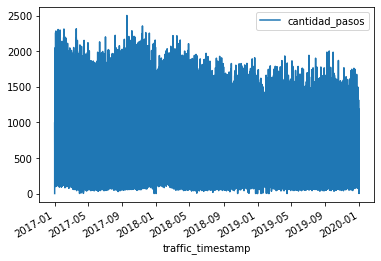

In [9]:
traffic_data[traffic_data['tipo_vehiculo'] == 'Liviano'].plot( 'traffic_timestamp', 'cantidad_pasos')

<AxesSubplot:xlabel='traffic_timestamp'>

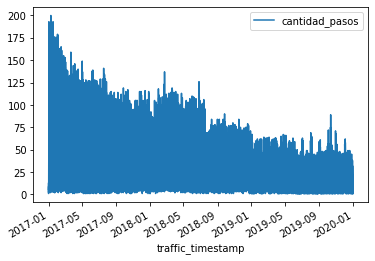

In [10]:
traffic_data[traffic_data['tipo_vehiculo'] == 'Pesado'].plot( 'traffic_timestamp', 'cantidad_pasos')

<AxesSubplot:xlabel='tipo_vehiculo', ylabel='cantidad_pasos'>

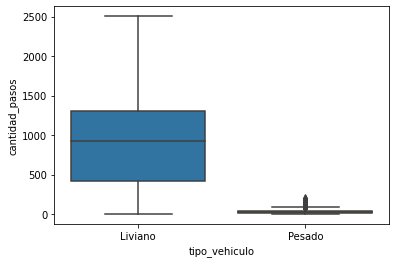

In [11]:
seaborn.boxplot(data=traffic_data, x='tipo_vehiculo', y='cantidad_pasos')

<AxesSubplot:xlabel='sentido', ylabel='cantidad_pasos'>

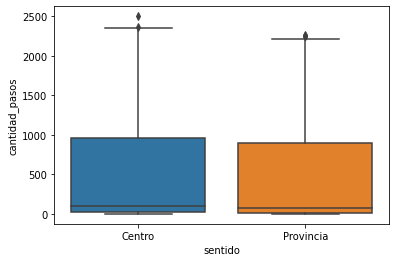

In [12]:
seaborn.boxplot(data=traffic_data, x='sentido', y='cantidad_pasos')

In [13]:
data_2019 = pandas.read_csv('traffic_data/flujo-vehicular-2019.csv', sep =',')
data_2018 = pandas.read_csv('traffic_data/flujo-vehicular-2018.csv', sep =',')
data_2017 = pandas.read_csv('traffic_data/flujo-vehicular-2017.csv', sep =',')
traffic_data = pandas.concat([data_2017, data_2018, data_2019])
traffic_data = traffic_data[traffic_data['estacion'] == 'Illia']
traffic_data = traffic_data[traffic_data['forma_pago'] == 'EFECTIVO']
traffic_data['traffic_timestamp'] = pandas.to_datetime(traffic_data['fecha']) + pandas.to_timedelta(traffic_data['hora_inicio'], unit= 'hours')
traffic_data = traffic_data.groupby(['traffic_timestamp'])['cantidad_pasos'].sum()
traffic_data = pandas.DataFrame(traffic_data)
traffic_data

,cantidad_pasos
traffic_timestamp,
2017-01-01 00:00:00,1
2017-01-01 01:00:00,1374
2017-01-01 02:00:00,1734
2017-01-01 03:00:00,1247
2017-01-01 04:00:00,579
...,...
2019-12-31 19:00:00,1374
2019-12-31 20:00:00,1706
2019-12-31 21:00:00,1139


# Feature Engineering

In [14]:

def generate_timedata(X):
    date_column = X.index.to_series()
    X['hour'] = date_column.dt.hour
    X['week'] = X.index.isocalendar().week
    X['day_week'] = X.index.isocalendar().day
    X['year'] = date_column.dt.year
    X['month'] = date_column.dt.month
    X['quarter'] = date_column.dt.quarter
    X['day_year'] = date_column.dt.dayofyear
    X['date'] = date_column.dt.date
    X['day'] = date_column.dt.day
    X['month_sin'] = numpy.sin(2*numpy.pi*X.month/12)
    X['month_cos'] = numpy.cos(2*numpy.pi*X.month/12)
    X['day_sin'] = numpy.sin(2*numpy.pi*X.day/30)
    X['day_cos'] = numpy.cos(2*numpy.pi*X.day/30)
    X['day_year_sin'] = numpy.sin(2*numpy.pi*X.day_year/365)
    X['day_year_cos'] = numpy.cos(2*numpy.pi*X.day_year/365)
    X['week_sin'] = numpy.sin(2*numpy.pi*X.week/52)
    X['week_cos'] = numpy.cos(2*numpy.pi*X.week/52)
    X['day_week_sin'] = numpy.sin(2*numpy.pi*X.day_week/7)
    X['day_week_cos'] = numpy.cos(2*numpy.pi*X.day_week/7)
    
    return X

In [15]:
generate_timedata(traffic_data)

,cantidad_pasos,hour,week,day_week,year,month,quarter,day_year,date,day,month_sin,month_cos,day_sin,day_cos,day_year_sin,day_year_cos,week_sin,week_cos,day_week_sin,day_week_cos
traffic_timestamp,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,1,0,52,7,2017,1,1,1,2017-01-01,1,5.000000e-01,0.866025,0.207912,0.978148,1.721336e-02,0.999852,0.0,1.0,-0.0,1.0
2017-01-01 01:00:00,1374,1,52,7,2017,1,1,1,2017-01-01,1,5.000000e-01,0.866025,0.207912,0.978148,1.721336e-02,0.999852,0.0,1.0,-0.0,1.0
2017-01-01 02:00:00,1734,2,52,7,2017,1,1,1,2017-01-01,1,5.000000e-01,0.866025,0.207912,0.978148,1.721336e-02,0.999852,0.0,1.0,-0.0,1.0
2017-01-01 03:00:00,1247,3,52,7,2017,1,1,1,2017-01-01,1,5.000000e-01,0.866025,0.207912,0.978148,1.721336e-02,0.999852,0.0,1.0,-0.0,1.0
2017-01-01 04:00:00,579,4,52,7,2017,1,1,1,2017-01-01,1,5.000000e-01,0.866025,0.207912,0.978148,1.721336e-02,0.999852,0.0,1.0,-0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,1374,19,1,2,2019,12,4,365,2019-12-31,31,-2.449294e-16,1.000000,0.207912,0.978148,6.432491e-16,1.000000,0.120537,0.992709,0.974928,-0.222521
2019-12-31 20:00:00,1706,20,1,2,2019,12,4,365,2019-12-31,31,-2.449294e-16,1.000000,0.207912,0.978148,6.432491e-16,1.000000,0.120537,0.992709,0.974928,-0.222521
2019-12-31 21:00:00,1139,21,1,2,2019,12,4,365,2019-12-31,31,-2.449294e-16,1.000000,0.207912,0.978148,6.432491e-16,1.000000,0.120537,0.992709,0.974928,-0.222521


<AxesSubplot:xlabel='day_week', ylabel='cantidad_pasos'>

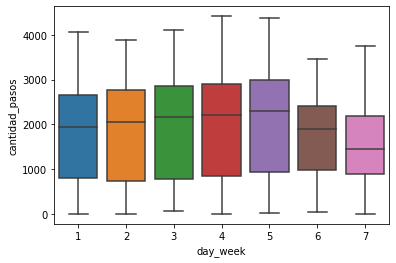

In [16]:
seaborn.boxplot(x = 'day_week', y = 'cantidad_pasos', data = traffic_data)

<AxesSubplot:xlabel='week', ylabel='cantidad_pasos'>

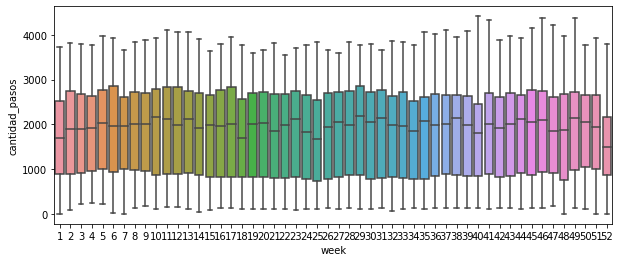

In [17]:
plt.figure(figsize=(10,4))
seaborn.boxplot(x = 'week', y = 'cantidad_pasos', data = traffic_data)

<AxesSubplot:xlabel='year', ylabel='cantidad_pasos'>

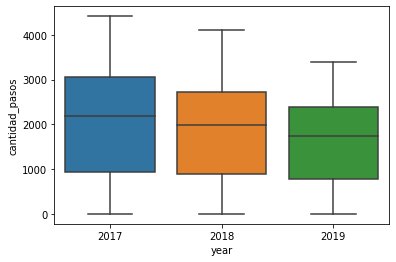

In [18]:
seaborn.boxplot(x = 'year', y = 'cantidad_pasos', data = traffic_data)

<AxesSubplot:xlabel='month', ylabel='cantidad_pasos'>

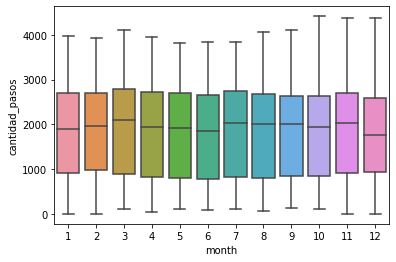

In [19]:
seaborn.boxplot(x = 'month', y = 'cantidad_pasos', data = traffic_data)

<AxesSubplot:xlabel='month', ylabel='cantidad_pasos'>

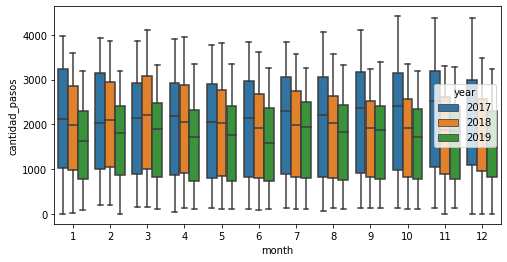

In [20]:
plt.figure(figsize=(8,4))
seaborn.boxplot(x = 'month', hue = 'year', y = 'cantidad_pasos', data = traffic_data)

<AxesSubplot:xlabel='day_week', ylabel='cantidad_pasos'>

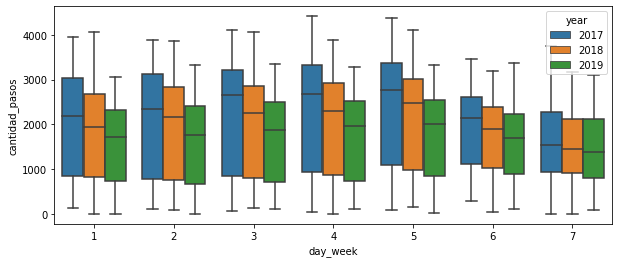

In [21]:
plt.figure(figsize=(10,4))
seaborn.boxplot(x = 'day_week', hue = 'year', y = 'cantidad_pasos', data = traffic_data)

<AxesSubplot:xlabel='hour', ylabel='cantidad_pasos'>

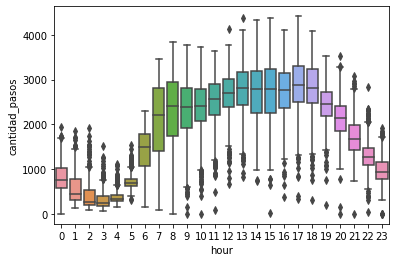

In [22]:
seaborn.boxplot(x = 'hour', y = 'cantidad_pasos', data = traffic_data)

<AxesSubplot:xlabel='hour', ylabel='cantidad_pasos'>

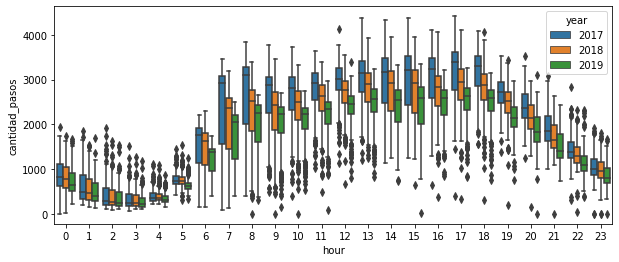

In [23]:
plt.figure(figsize=(10,4))
seaborn.boxplot(x = 'hour', y = 'cantidad_pasos', hue='year', data = traffic_data)

<AxesSubplot:xlabel='date'>

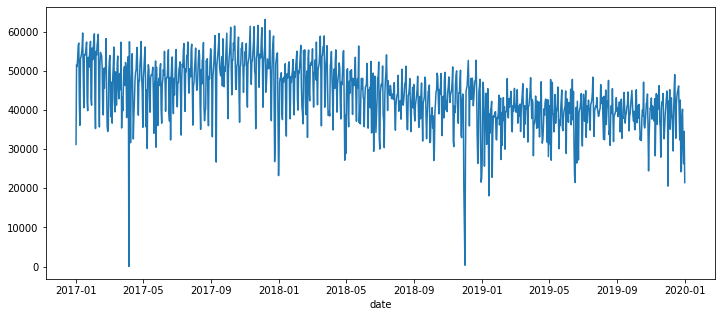

In [24]:
traffic_data.groupby('date')['cantidad_pasos'].sum().plot(x='date', y='cantidad_pasos', figsize=(12,5))

<AxesSubplot:>

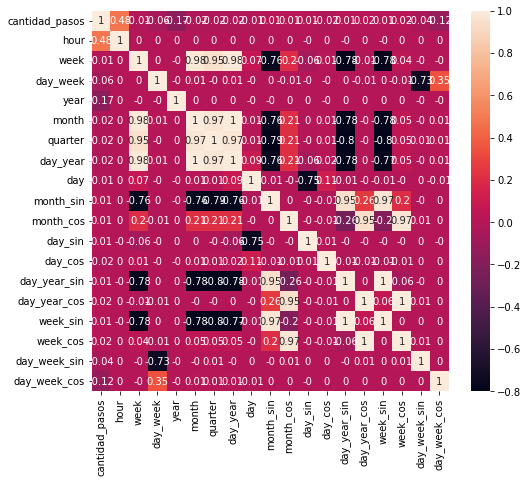

In [25]:
plt.figure(figsize=(10,9))
seaborn.heatmap(traffic_data.corr().round(2), cbar=True, annot=True)

## Modelo Predictivo

In [60]:
data_2019 = pandas.read_csv('traffic_data/flujo-vehicular-2019.csv', sep =',')
data_2018 = pandas.read_csv('traffic_data/flujo-vehicular-2018.csv', sep =',')
data_2017 = pandas.read_csv('traffic_data/flujo-vehicular-2017.csv', sep =',')
traffic_data = pandas.concat([data_2017, data_2018, data_2019])
traffic_data = traffic_data[traffic_data['estacion'] == 'Illia']
traffic_data = traffic_data[traffic_data['forma_pago'] == 'EFECTIVO']
traffic_data['traffic_timestamp'] = pandas.to_datetime(traffic_data['fecha'])
traffic_data = traffic_data.resample('D', on='traffic_timestamp').sum()['cantidad_pasos']
traffic_data


traffic_timestamp
2017-01-01    31183
2017-01-02    51568
2017-01-03    51093
2017-01-04    53332
2017-01-05    56486
              ...  
2019-12-27    40182
2019-12-28    30681
2019-12-29    26259
2019-12-30    34523
2019-12-31    21447
Freq: D, Name: cantidad_pasos, Length: 1095, dtype: int64

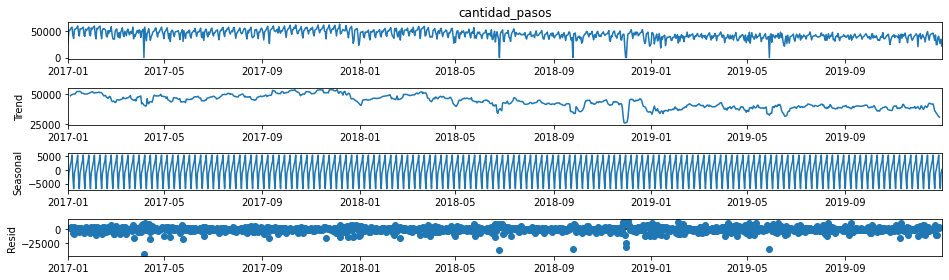

In [27]:
import statsmodels as sm
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(traffic_data, model='additive')
fig = result.plot()
fig.set_figwidth(15)

In [61]:

def generate_timedata(X):
    date_column = X.index.to_series()
    X['week'] = X.index.isocalendar().week
    X['day_week'] = X.index.isocalendar().day
    X['year'] = date_column.dt.year
    X['month'] = date_column.dt.month
    X['quarter'] = date_column.dt.quarter
    X['day_year'] = date_column.dt.dayofyear
    X['date'] = date_column.dt.date
    X['day'] = date_column.dt.day
    X['month_sin'] = numpy.sin(2*numpy.pi*X.month/12)
    X['month_cos'] = numpy.cos(2*numpy.pi*X.month/12)
    X['day_sin'] = numpy.sin(2*numpy.pi*X.day/30)
    X['day_cos'] = numpy.cos(2*numpy.pi*X.day/30)
    X['day_year_sin'] = numpy.sin(2*numpy.pi*X.day_year/365)
    X['day_year_cos'] = numpy.cos(2*numpy.pi*X.day_year/365)
    X['week_sin'] = numpy.sin(2*numpy.pi*X.week/52)
    X['week_cos'] = numpy.cos(2*numpy.pi*X.week/52)
    X['day_week_sin'] = numpy.sin(2*numpy.pi*X.day_week/7)
    X['day_week_cos'] = numpy.cos(2*numpy.pi*X.day_week/7)
    
    return X

In [62]:
traffic_data = pandas.DataFrame(traffic_data)
daily_data = generate_timedata(traffic_data)
daily_data

,cantidad_pasos,week,day_week,year,month,quarter,day_year,date,day,month_sin,month_cos,day_sin,day_cos,day_year_sin,day_year_cos,week_sin,week_cos,day_week_sin,day_week_cos
traffic_timestamp,,,,,,,,,,,,,,,,,,,
2017-01-01,31183,52,7,2017,1,1,1,2017-01-01,1,5.000000e-01,0.866025,2.079117e-01,0.978148,1.721336e-02,0.999852,0.0,1.0,-0.0,1.0
2017-01-02,51568,1,1,2017,1,1,2,2017-01-02,2,5.000000e-01,0.866025,4.067366e-01,0.913545,3.442161e-02,0.999407,0.120537,0.992709,0.781831,0.62349
2017-01-03,51093,1,2,2017,1,1,3,2017-01-03,3,5.000000e-01,0.866025,5.877853e-01,0.809017,5.161967e-02,0.998667,0.120537,0.992709,0.974928,-0.222521
2017-01-04,53332,1,3,2017,1,1,4,2017-01-04,4,5.000000e-01,0.866025,7.431448e-01,0.669131,6.880243e-02,0.997630,0.120537,0.992709,0.433884,-0.900969
2017-01-05,56486,1,4,2017,1,1,5,2017-01-05,5,5.000000e-01,0.866025,8.660254e-01,0.500000,8.596480e-02,0.996298,0.120537,0.992709,-0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,40182,52,5,2019,12,4,361,2019-12-27,27,-2.449294e-16,1.000000,-5.877853e-01,0.809017,-6.880243e-02,0.997630,0.0,1.0,-0.974928,-0.222521
2019-12-28,30681,52,6,2019,12,4,362,2019-12-28,28,-2.449294e-16,1.000000,-4.067366e-01,0.913545,-5.161967e-02,0.998667,0.0,1.0,-0.781831,0.62349
2019-12-29,26259,52,7,2019,12,4,363,2019-12-29,29,-2.449294e-16,1.000000,-2.079117e-01,0.978148,-3.442161e-02,0.999407,0.0,1.0,-0.0,1.0


In [63]:
daily_data['date'] = pandas.to_datetime(daily_data['date'])
daily_data

,cantidad_pasos,week,day_week,year,month,quarter,day_year,date,day,month_sin,month_cos,day_sin,day_cos,day_year_sin,day_year_cos,week_sin,week_cos,day_week_sin,day_week_cos
traffic_timestamp,,,,,,,,,,,,,,,,,,,
2017-01-01,31183,52,7,2017,1,1,1,2017-01-01,1,5.000000e-01,0.866025,2.079117e-01,0.978148,1.721336e-02,0.999852,0.0,1.0,-0.0,1.0
2017-01-02,51568,1,1,2017,1,1,2,2017-01-02,2,5.000000e-01,0.866025,4.067366e-01,0.913545,3.442161e-02,0.999407,0.120537,0.992709,0.781831,0.62349
2017-01-03,51093,1,2,2017,1,1,3,2017-01-03,3,5.000000e-01,0.866025,5.877853e-01,0.809017,5.161967e-02,0.998667,0.120537,0.992709,0.974928,-0.222521
2017-01-04,53332,1,3,2017,1,1,4,2017-01-04,4,5.000000e-01,0.866025,7.431448e-01,0.669131,6.880243e-02,0.997630,0.120537,0.992709,0.433884,-0.900969
2017-01-05,56486,1,4,2017,1,1,5,2017-01-05,5,5.000000e-01,0.866025,8.660254e-01,0.500000,8.596480e-02,0.996298,0.120537,0.992709,-0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,40182,52,5,2019,12,4,361,2019-12-27,27,-2.449294e-16,1.000000,-5.877853e-01,0.809017,-6.880243e-02,0.997630,0.0,1.0,-0.974928,-0.222521
2019-12-28,30681,52,6,2019,12,4,362,2019-12-28,28,-2.449294e-16,1.000000,-4.067366e-01,0.913545,-5.161967e-02,0.998667,0.0,1.0,-0.781831,0.62349
2019-12-29,26259,52,7,2019,12,4,363,2019-12-29,29,-2.449294e-16,1.000000,-2.079117e-01,0.978148,-3.442161e-02,0.999407,0.0,1.0,-0.0,1.0


In [64]:
train_data = daily_data[daily_data.index < datetime(2019, 10, 1)].copy()
test_data = daily_data[daily_data.index >= datetime(2019, 10, 1)].reset_index(drop=True).copy()

In [65]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

In [66]:
X_train = train_data.drop(columns= ['cantidad_pasos', 'date']).copy()
y_train = train_data['cantidad_pasos'].copy()
X_test = test_data.drop(columns= ['cantidad_pasos', 'date']).copy()
y_test = test_data['cantidad_pasos'].copy()

In [67]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [68]:
y_pred = lr.predict(X_test)
r2_score(y_test, y_pred)

0.24424734488919309

In [69]:
mean_absolute_error(y_test, y_pred)

3798.8353230800562

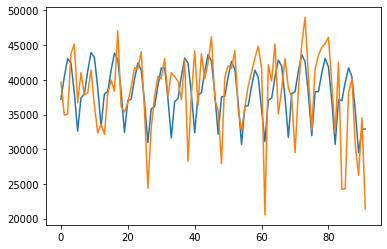

In [70]:
plt.plot(y_pred)
plt.plot(y_test)

In [71]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

In [72]:
rfr = RandomForestRegressor()

rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
r2_score(y_test, y_pred)

0.3214575809527386

In [73]:
mean_absolute_error(y_test, y_pred)

3420.420434782608

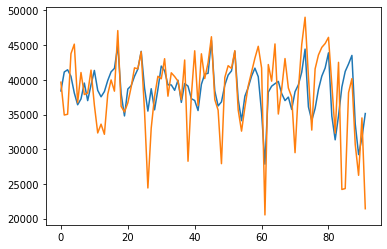

In [74]:
plt.plot(y_pred)
plt.plot(y_test)

In [119]:
rfr_opt = RandomForestRegressor()
params = {'max_depth': [x for x in range(1,30,1)],
         'max_features': ['auto','log2', None],
         'n_estimators': [x for x in range(25,125,10)]}

rfr_opt = RandomizedSearchCV(estimator = rfr_opt, param_distributions = params, n_iter = 50,
                                cv = 4, scoring = 'neg_mean_squared_error', random_state=42, n_jobs = -1)

rfr_opt.fit(X_train, y_train)
y_pred = rfr_opt.predict(X_test)
r2_score(y_test, y_pred)

0.3269249512994662

In [121]:
mean_absolute_error(y_test, y_pred)

3432.740424622345

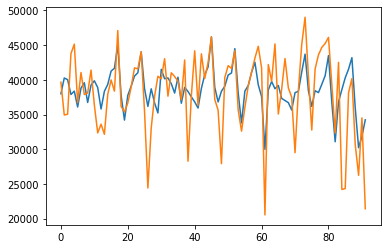

In [120]:
plt.plot(y_pred)
plt.plot(y_test)

In [45]:
X_train

,week,day_week,year,month,quarter,day_year,day,month_sin,month_cos,day_sin,day_cos,day_year_sin,day_year_cos,week_sin,week_cos,day_week_sin,day_week_cos
traffic_timestamp,,,,,,,,,,,,,,,,,
2017-01-01,52,7,2017,1,1,1,1,0.500000,0.866025,2.079117e-01,0.978148,0.017213,0.999852,0.0,1.0,-0.0,1.0
2017-01-02,1,1,2017,1,1,2,2,0.500000,0.866025,4.067366e-01,0.913545,0.034422,0.999407,0.120537,0.992709,0.781831,0.62349
2017-01-03,1,2,2017,1,1,3,3,0.500000,0.866025,5.877853e-01,0.809017,0.051620,0.998667,0.120537,0.992709,0.974928,-0.222521
2017-01-04,1,3,2017,1,1,4,4,0.500000,0.866025,7.431448e-01,0.669131,0.068802,0.997630,0.120537,0.992709,0.433884,-0.900969
2017-01-05,1,4,2017,1,1,5,5,0.500000,0.866025,8.660254e-01,0.500000,0.085965,0.996298,0.120537,0.992709,-0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-27,35,2,2019,8,3,239,27,-0.866025,-0.500000,-5.877853e-01,0.809017,-0.826354,-0.563151,-0.885456,-0.464723,0.974928,-0.222521
2019-08-28,35,3,2019,8,3,240,28,-0.866025,-0.500000,-4.067366e-01,0.913545,-0.835925,-0.548843,-0.885456,-0.464723,0.433884,-0.900969
2019-08-29,35,4,2019,8,3,241,29,-0.866025,-0.500000,-2.079117e-01,0.978148,-0.845249,-0.534373,-0.885456,-0.464723,-0.433884,-0.900969


In [76]:
train_prophet = pandas.DataFrame(y_train, index= X_train.index).reset_index()
train_prophet.columns = ['ds', 'y']
train_prophet

,ds,y
0,2017-01-01,31183
1,2017-01-02,51568
2,2017-01-03,51093
3,2017-01-04,53332
4,2017-01-05,56486
...,...,...
998,2019-09-26,43110
999,2019-09-27,44985
1000,2019-09-28,41925
1001,2019-09-29,38348


In [112]:
prophet_model = Prophet(interval_width=0.8)
prophet_model.fit(train_prophet)
future_dates = prophet_model.make_future_dataframe(periods=92, freq='D')
future_dates.head()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/juancparra/.local/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -25.2003
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       1891.19   0.000426765       86.2386    3.49e-06       0.001      152  LS failed, Hessian reset 
      99       1891.26   0.000262479       54.6255      0.2107           1      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       1891.29   0.000126892       76.0508   2.137e-06       0.001      222  LS failed, Hessian reset 
     191        1891.5    0.00126033       73.1851   1.573e-05       0.001      371  LS failed, Hessian reset 
     199       1891.55   0.000109738       62.9752      0.5475      0.5475      380   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     265       1891.68   7.05867e-08        62.717      0.2397           1      467   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

,ds
0,2017-01-01
1,2017-01-02
2,2017-01-03
3,2017-01-04
4,2017-01-05


In [113]:
forecast = prophet_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

/home/juancparra/.local/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/juancparra/.local/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,ds,yhat,yhat_lower,yhat_upper
0,2017-01-01,39281.827547,31513.270441,46503.177565
1,2017-01-02,45051.486228,37741.618056,52874.153495
2,2017-01-03,46206.693142,38987.804756,53475.836681
3,2017-01-04,47983.396669,40427.687336,55466.773266
4,2017-01-05,49024.540681,41412.964640,56405.438110


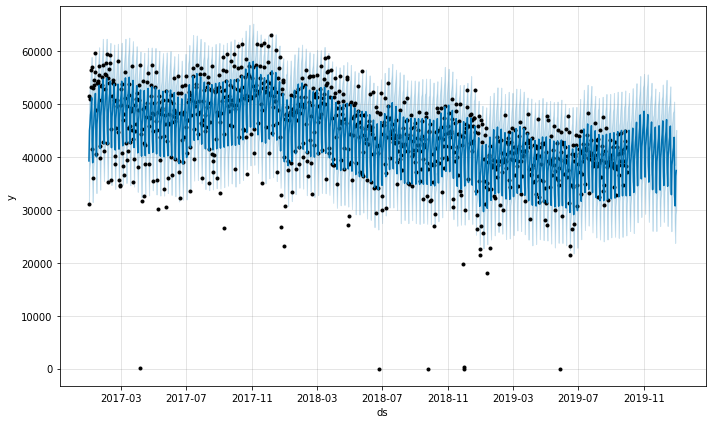

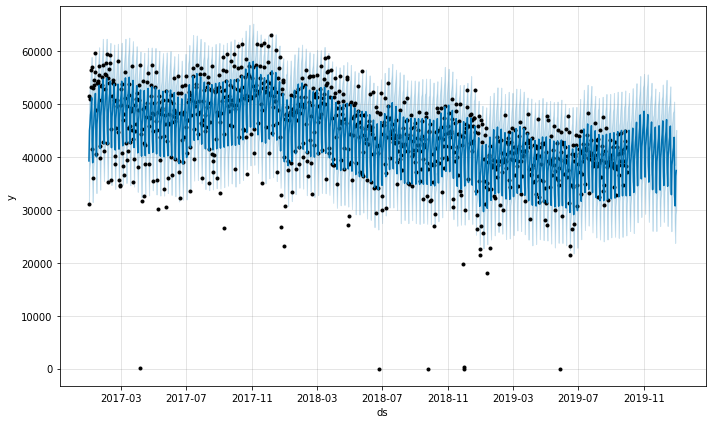

In [114]:
prophet_model.plot(forecast, uncertainty=True)

In [115]:
y_pred = forecast[forecast['ds'] >= datetime(2019,10,1)]['yhat']
y_pred.reset_index(drop=True, inplace=True)

In [116]:
r2_score(y_test, y_pred)

-0.018876792307997103

In [117]:
mean_absolute_error(y_test, y_pred)

4240.252172415294

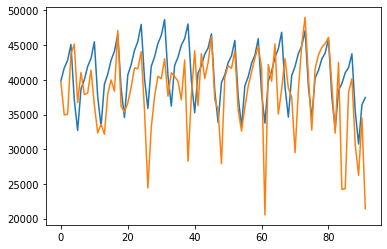

In [118]:
plt.plot(y_pred)
plt.plot(y_test)

<BarContainer object of 17 artists>

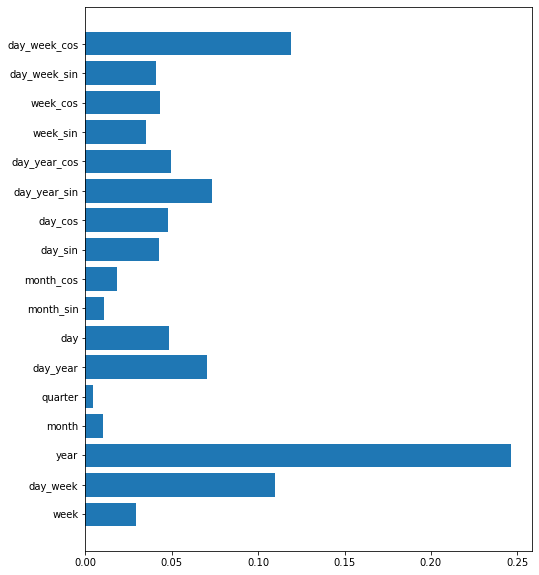

In [132]:
plt.figure(figsize=(8,10))
plt.barh(y = X_train.columns, width = rfr.feature_importances_)